In [2]:
import sys

In [3]:
from nutil import *

In [5]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import learning_curve

In [6]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [24]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        x = np.array(Counter(y).most_common())
        x[:,1] /= x[:,1].sum()
        self.probabilities_ = x
        

        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        n, d = X.shape
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        y = np.random.choice(self.probabilities_[:,0], n, p=self.probabilities_[:,1])
        
        ### ========== TODO : END ========== ###

        return y


In [8]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [41]:
######################################################################
# Mutatble functions
######################################################################
import warnings
from sklearn.exceptions import ConvergenceWarning

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.
    
    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    splitter = StratifiedShuffleSplit(n_splits = ntrials, test_size=test_size,random_state=0)

    ### ========== TODO : START ========== ###
    # part e:
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use StratifiedShuffleSplit (be careful of the parameters)
    train_error = 0
    test_error = 0
    f1_score = 0
    for i, (train_index, test_index) in enumerate(splitter.split(X,y)):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            clf.fit(X[train_index],y[train_index])
        y_pred_train = clf.predict(X[train_index])
        y_pred_test = clf.predict(X[test_index])
        train_error += 1 - metrics.accuracy_score(y[train_index], y_pred_train, normalize=True)
        test_error += 1 - metrics.accuracy_score(y[test_index], y_pred_test, normalize=True)
        f1_score += metrics.f1_score(y[test_index], y_pred_test)
    ### ========== TODO : END ========== ###
    train_error /= ntrials
    test_error /= ntrials
    f1_score /= ntrials

    return train_error, test_error, f1_score




In [10]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


In [11]:
######################################################################
# main
######################################################################
    
# load adult_subsample dataset with correct file path

### ========== TODO : START ========== ###
# for example data_file =  "/content/drive/My Drive/cs146/hw1/adult_subsample.csv"
data_file = "adult_subsample.csv"
### ========== TODO : END ========== ###

data = load_data(data_file, header=1, predict_col=-1)

X = data.X; Xnames = data.Xnames
y = data.y; yname = data.yname
n,d = X.shape  # n = number of examples, d =  number of features


Plotting...


<Figure size 640x480 with 0 Axes>

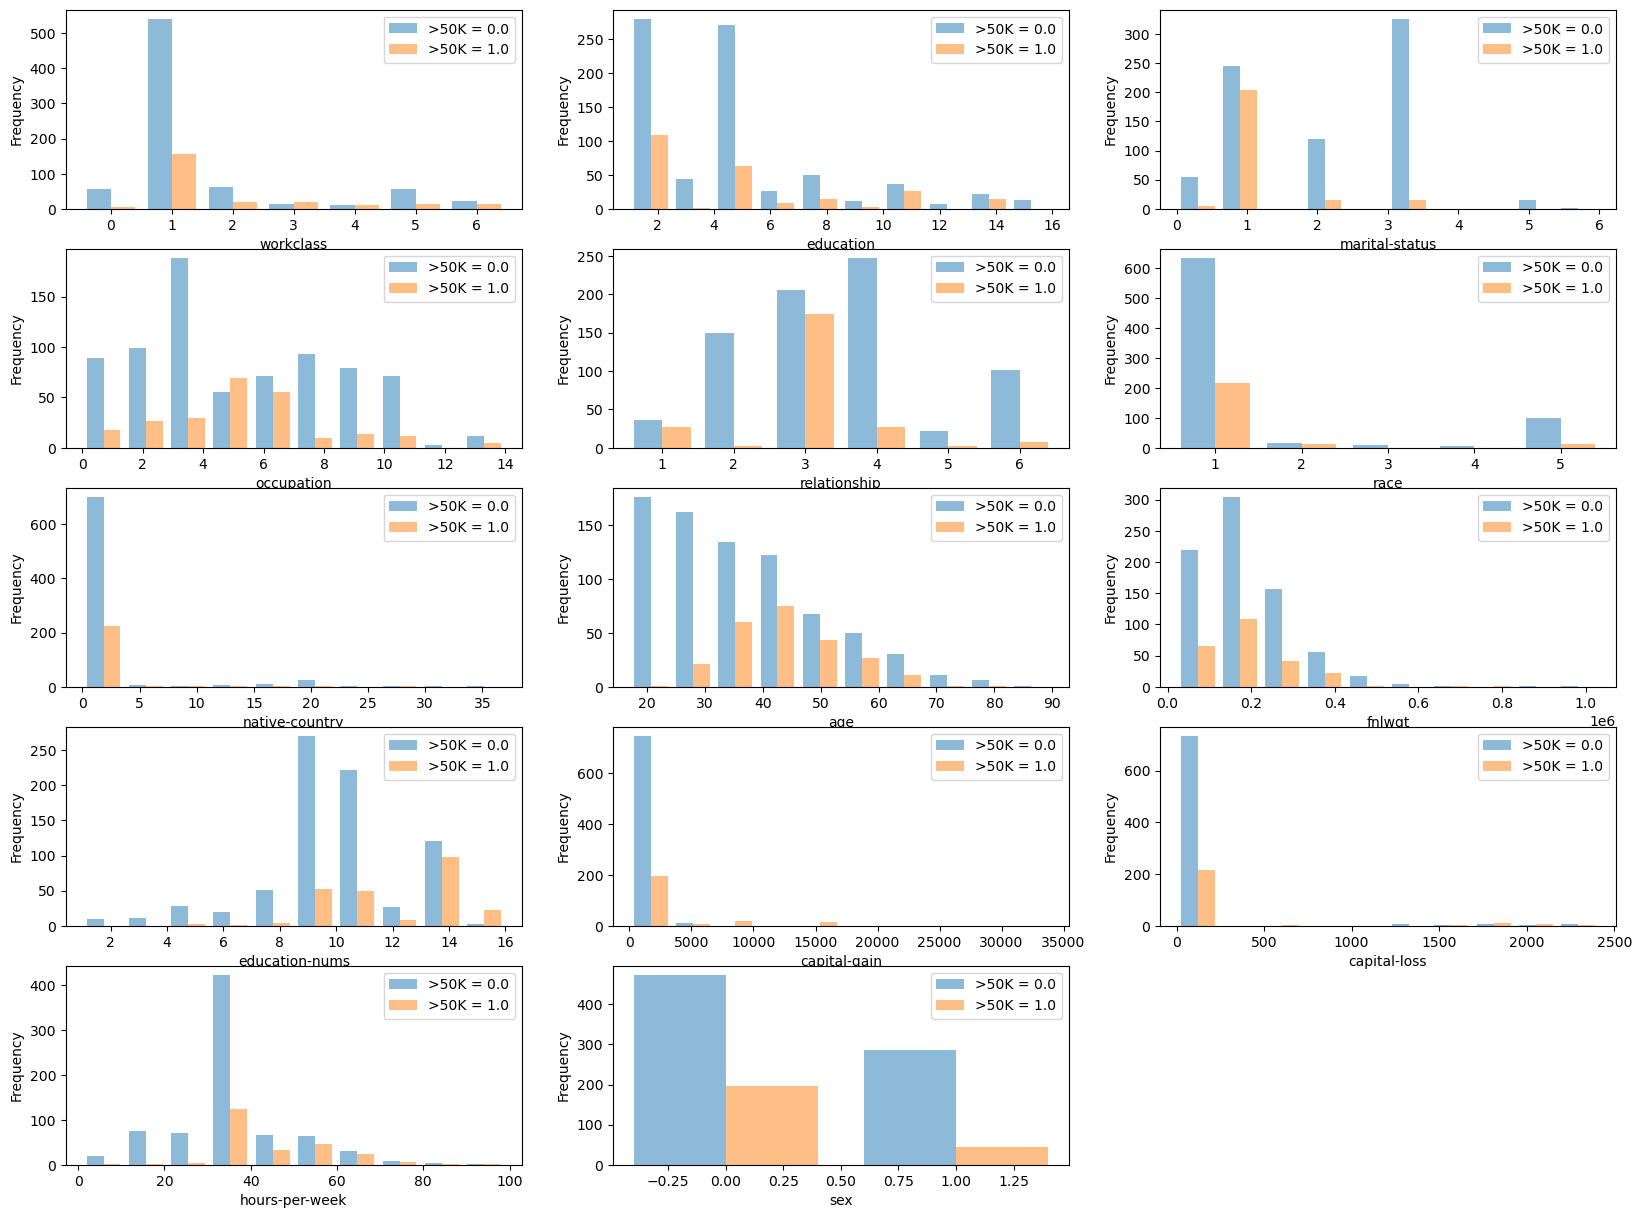

In [25]:
plt.figure()
#========================================
# part a: plot histograms of each feature
print('Plotting...')
plot_histograms (X, y, Xnames=Xnames, yname=yname)

1. Workclass: Most samples are from workclass 1. Workclass 3 is the only class that has more >50k.
2. education: class 14 and 11 look like the highest salary. Most education is between 1 and 5.
3. Marital status: class 1 has the only high proportion of >50k. Additionally not many people are in class 6.
4. occupation: class 5 has the only higher percentage of >50k.
5. relationship: class 3 has the highest percentage of >50k Class 4 has the largest num samples
6. race: most samples are in class 1 or 5
7. native country: almost everyone is class 1.
8. age. the <50k looks linear decreasing with age and >50k looks normal centered around 45.
9. fnlwgt: most classes have about 2e5 plus or minus 1e5.
10. education nums: class 15 has very high proportion >50k and it seems like higher class is positively correlated with higher salary.
11. capital-gain: most is centered around 0, but as it increases so does salary.
12. capital-loss: most is centered around 0.
13. hours per week: most is around 40. The higher the hours looks like the higher the salary correlation.
14. sex: men have higher percenate >50k and are more represented in the data.

In [26]:
#========================================
# train Majority Vote classifier on data
print('Classifying using Majority Vote...')
clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

Classifying using Majority Vote...
	-- training error: 0.240


In [28]:
### ========== TODO : START ========== ###
# part b: evaluate training error of Random classifier
print('Classifying using Random Vote...')
clf = RandomClassifier() # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)
### ========== TODO : END ========== ###

Classifying using Random Vote...
	-- training error: 0.374


In [29]:
### ========== TODO : START ========== ###
print('Classifying using Decision Tree Classifier Vote...')
clf = DecisionTreeClassifier(criterion='entropy') # create decision tree classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)
# part c: evaluate training error of Decision Tree classifier

### ========== TODO : END ========== ###

Classifying using Decision Tree Classifier Vote...
	-- training error: 0.000


In [32]:
### ========== TODO : START ========== ###
# part d: evaluate training error of k-Nearest Neighbors classifier
# use k = 3, 5, 7 for n_neighbors
print('Classifying using K nearest neighbors...')
for k in [3,5,7]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X,y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print(f'\t -- training error for k={k}: {train_error:.3f}')

### ========== TODO : END ========== ###

Classifying using K nearest neighbors...
	 -- training error for k=3: 0.153
	 -- training error for k=5: 0.195
	 -- training error for k=7: 0.213


In [ ]:
### ========== TODO : START ========== ###
# part e: evaluate training error of Logistic Regression
# use lambda_ = 0.1, 1, 10 for n_neighbors
import warnings
from sklearn.exceptions import ConvergenceWarning

for lambda_ in [0.1,1,10]:
    clf = LogisticRegression(random_state=0,max_iter=1000,C=1/lambda_)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        clf.fit(X, y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y,y_pred,normalize=True)
    print(f'\t -- training error for lambda={lambda_}: {train_error:.3f}')

	 -- training error for lambda=0.1: 0.181
	 -- training error for lambda=1: 0.181
	 -- training error for lambda=10: 0.182


In [62]:
### ========== TODO : START ========== ###
# part f: use cross-validation to compute average training and test error of classifiers
print('Investigating various classifiers...')
classifiers = [(RandomClassifier(),"random"),(DecisionTreeClassifier(criterion='entropy'),"decision Tree entroopy"),(KNeighborsClassifier(n_neighbors=5), "KNeighbors k =5"),(LogisticRegression(random_state=0,max_iter=1000,C=1),"Logistic Regression lambda = 1")]
for (clf,name) in classifiers:
    train_error, test_error, f1_score = error(clf, X, y, ntrials=100, test_size=0.15)
    print(f"\t -- for classifier: {name} training error: {train_error:.3f}, test_error: {test_error:.3f}, f1_score: {f1_score:.3f} ")

### ========== TODO : END ========== ###

Investigating various classifiers...
	 -- for classifier: random training error: 0.372, test_error: 0.367, f1_score: 0.247 
	 -- for classifier: decision Tree entroopy training error: 0.000, test_error: 0.202, f1_score: 0.579 
	 -- for classifier: KNeighbors k =5 training error: 0.200, test_error: 0.254, f1_score: 0.162 
	 -- for classifier: Logistic Regression lambda = 1 training error: 0.181, test_error: 0.190, f1_score: 0.543 


Finding the best k...


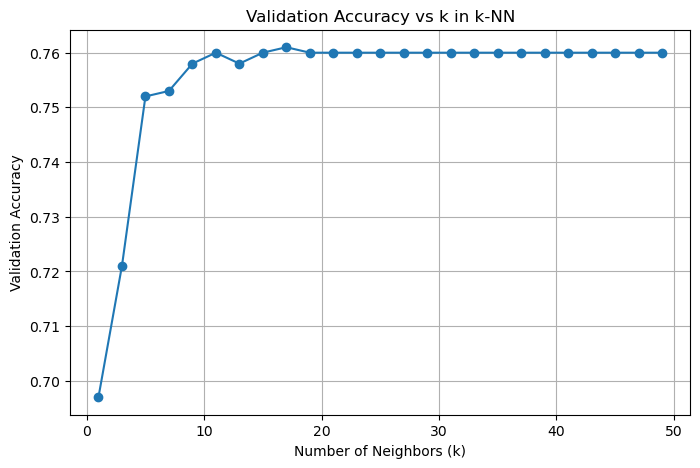

17 0.7609999999999999


In [52]:
### ========== TODO : START ========== ###
# part g: use 5-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
print('Finding the best k...')
val_scores = np.zeros(25)
k_vals = np.arange(1, 51, 2)
for i in range(0,25):
    k = k_vals[i]
    clf = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(clf,X,y, cv=5)
    val_scores[i] = score.mean()

plt.figure(figsize=(8, 5))
plt.plot(k_vals, val_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs k in k-NN')
plt.grid(True)
plt.show()
index = val_scores.argmax()

print(k_vals[index], val_scores[index])

### ========== TODO : END ========== ###

The best k value is 17 with score 0.761. Based on the graph it seems that too small k values increases the noise of the prediction resulting in low validation accuracy, but after about 17  the accuracy plateaus which shows that it is effectively averaging over the near neighbors.

Investigating depths...


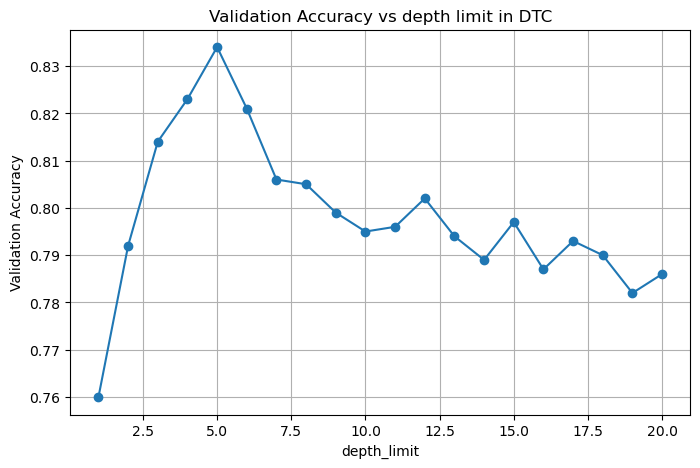

5 0.834


In [60]:
### ========== TODO : START ========== ###
# part h: investigate decision tree classifier with various depths
print('Investigating depths...')
val_scores = np.zeros(20)
depth_limits = np.arange(1, 21, 1)
for i in range(20):
    depth_limit = depth_limits[i]
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth_limit)
    score = cross_val_score(clf,X,y, cv=5)
    val_scores[i] = score.mean()

plt.figure(figsize=(8, 5))
plt.plot(depth_limits, val_scores, marker='o')
plt.xlabel('depth_limit')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs depth limit in DTC')
plt.grid(True)
plt.show()
index = val_scores.argmax()

print(depth_limits[index], val_scores[index])
### ========== TODO : END ========== ###

The best depth limit for this training set is 5. There is overfitting as can be seen by the consistent decrease in validation accuracy as the depth goes from 6 to 20. Underfitting is also present for depths below 5. This can all be seen by the plot increasing sharply and then decreasing steadily for depth > 5.

In [61]:
print('Done')

Done
